Install Dependencies

In [1]:
!pip install datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00


Load Modules and Define Helper Functions

In [2]:
import os
import time
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader


####### Conceptual Concepts (CC3M) Code from Huggingface #########
from concurrent.futures import ThreadPoolExecutor
from functools import partial
import io
import urllib

import PIL.Image

from datasets import load_dataset
from datasets.utils.file_utils import get_datasets_user_agent


USER_AGENT = get_datasets_user_agent()


def fetch_single_image(image_url, timeout=None, retries=0):
    for _ in range(retries + 1):
        try:
            request = urllib.request.Request(
                image_url,
                data=None,
                headers={"user-agent": USER_AGENT},
            )
            with urllib.request.urlopen(request, timeout=timeout) as req:
                image = PIL.Image.open(io.BytesIO(req.read()))
            break
        except Exception:
            image = None
    return image


def fetch_images(batch, num_threads, timeout=None, retries=0):
    fetch_single_image_with_args = partial(fetch_single_image, timeout=timeout, retries=retries)
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        batch["image"] = list(executor.map(fetch_single_image_with_args, batch["image_url"]))
    return batch

#############################################################



Build Directory Structure

In [3]:
import os

basedir = 'Fake2M'
for split in ['train', 'val']:
    for label in ['fake', 'real']:
        path = os.path.join(basedir, split, label)
        if not os.path.exists(path):
            os.makedirs(path)

Helper Functions for retrieving data to create dataset

In [4]:
def iterate_urls_like(url, count):
    left, right = url.split('.tar.gz.')
    num, right = right.split('?')
    pad = len(num)
    urls = []
    for idx in range(count):
        urls += [f'{left}.tar.gz.{idx:0>{pad}}?{right}']
    return urls

def download_fake2m_tarball(url, label='fake', split='train'):
    start_time = time.time()
    print(f"Downloading Tarball from {url}")
    t0 = time.time()
    os.system(f'wget {url}')
    print(f"Downloaded Tarball in {time.time() - t0:.1f} seconds")
    fname = url.split('/')[-1]
    new_fname = fname.split('?')[0]
    os.rename(fname, new_fname)
    print("Untarring Tarball")
    t0 = time.time()
    os.system(f'tar -xvzf {new_fname} -C Fake2M/{split}/{label}')
    print(f"Untarred Tarball in {time.time() - t0:.1f} seconds")
    os.remove(new_fname)
    elapsed = time.time() - start_time
    return elapsed

def get_cc3m_images(num_train, num_val, num_threads=100, timeout=5, batch_size=500):

    if not os.path.exists('Fake2M/train/real/CC3M'):
        os.makedirs('Fake2M/train/real/CC3M')
    if not os.path.exists('Fake2M/val/real/CC3M'):
        os.makedirs('Fake2M/val/real/CC3M')

    train_pct = num_train / (num_train + num_val)

    max_images = num_train + num_val
    cc3m_dataset = load_dataset("conceptual_captions", split='train', streaming=True)
    subset = cc3m_dataset.take(max_images)
    image_urls = [d['image_url'] for d in subset]
    image_captions = [d['caption'] for d in subset]
    subset = {'image_url':image_urls, 'caption':image_captions}

    # Estimate 45 sec total for 1000 images (20s download, 25s write to disk)
    for start in range(0, max_images, batch_size):
        batch = {
            'image_url': image_urls[start:start+batch_size],
            'caption': image_captions[start:start+batch_size]
        }

        batch = fetch_images(batch, num_threads=num_threads, timeout=timeout)

        for i,img in enumerate(batch['image']):
            i = start + i
            if img:
                split = 'train' if i < num_train else 'val'
                try:
                    img.save(f'Fake2M/{split}/real/CC3M/{i:>07}.jpg')
                except:
                    print(f"Could not write image {i} to disk")


In [5]:
# train fake urls
sdv15_cc1m_url = "https://huggingface.co/datasets/InfImagine/FakeImageDataset/resolve/main/ImageData/train/SDv15R-CC1M/SDv15R-dpmsolver-25-1M/SDv15R-CC1M.tar.gz.000?download=true"
if_1m_url = "https://huggingface.co/datasets/InfImagine/FakeImageDataset/resolve/main/ImageData/train/IFv1-CC1M/IFv1-dpmsolver%2B%2B-50-1M/IF-CC1M.tar.gz.00?download=true"
stylegan3_80k_url = "https://huggingface.co/datasets/InfImagine/FakeImageDataset/resolve/main/ImageData/train/stylegan3-80K/stylegan3-80K.tar.gz.00?download=true"

# val fake urls
if_cc95k_url = "https://huggingface.co/datasets/InfImagine/FakeImageDataset/resolve/main/ImageData/val/IF-CC95K/IF-CC95K.tar.gz.0?download=true"
sdv15_cc30k_url = "https://huggingface.co/datasets/InfImagine/FakeImageDataset/resolve/main/ImageData/val/SDv15-CC30K/SDv15-CC30K.tar.gz.0?download=true"
sdv21_cc15k_url = "https://huggingface.co/datasets/InfImagine/FakeImageDataset/resolve/main/ImageData/val/SDv21-CC15K/SDv21-CC15K.tar.gz.0?download=true"
cogview2_22k_url = "https://huggingface.co/datasets/InfImagine/FakeImageDataset/resolve/main/ImageData/val/cogview2-22K/cogview2-22K.tar.gz.0?download=true"
stylegan3_60k_url = "https://huggingface.co/datasets/InfImagine/FakeImageDataset/resolve/main/ImageData/val/stylegan3-60K/stylegan3-60K.tar.gz.00?download=true"
midjourney_5k_url = "https://huggingface.co/datasets/InfImagine/FakeImageDataset/resolve/main/ImageData/val/Midjourneyv5-5K/Midjourneyv5-5K.tar.gz?download=true"

for url_template, count, split, label in [
    (sdv15_cc1m_url, 2, 'train', 'fake'), # Max 124
    (if_1m_url, 2, 'train', 'fake'), # Max 38
    (stylegan3_80k_url, 2, 'train', 'fake'), # Max 32
    (if_cc95k_url, 1, 'val', 'fake'), # Max 4
    (sdv15_cc30k_url, 1, 'val', 'fake'), # Max 5
    (sdv21_cc15k_url, 1, 'val', 'fake'), # Max 3
    (cogview2_22k_url, 1, 'val', 'fake'), # Max 2
    (stylegan3_60k_url, 1, 'val', 'fake'), # Max 20
    (midjourney_5k_url, 1, 'val', 'fake'), # Max 1

]:
    if count > 1:
        for url in iterate_urls_like(url_template, count):
            download_fake2m_tarball(url, label, split)
    else:
        download_fake2m_tarball(url_template, label, split)

Downloaded Tarball in 91.3 seconds
Untarring Tarball
Untarred Tarball in 22.4 seconds
Downloaded Tarball in 83.6 seconds
Untarring Tarball
Untarred Tarball in 0.0 seconds
Downloaded Tarball in 82.6 seconds
Untarring Tarball
Untarred Tarball in 23.3 seconds
Downloaded Tarball in 80.2 seconds
Untarring Tarball
Untarred Tarball in 0.0 seconds
Downloaded Tarball in 85.4 seconds
Untarring Tarball
Untarred Tarball in 22.4 seconds
Downloaded Tarball in 101.5 seconds
Untarring Tarball
Untarred Tarball in 0.0 seconds
Downloaded Tarball in 82.1 seconds
Untarring Tarball
Untarred Tarball in 23.3 seconds
Downloaded Tarball in 86.7 seconds
Untarring Tarball
Untarred Tarball in 22.3 seconds
Downloaded Tarball in 79.5 seconds
Untarring Tarball
Untarred Tarball in 22.1 seconds
Downloaded Tarball in 83.0 seconds
Untarring Tarball
Untarred Tarball in 31.3 seconds
Downloaded Tarball in 81.1 seconds
Untarring Tarball
Untarred Tarball in 22.2 seconds
Downloaded Tarball in 31.8 seconds
Untarring Tarball
Unt

In [6]:
# get real images from cc3m for train and val datasets

#### Notes on retrieving the data #####
# 45 sec for 1000 images => 4500 sec (1.25 hrs) for 100K Imges => 12.5hrs for 1M images
# Do we have enough storage for this? Would crop/resizing everything to 256 be enough space?
# Preliminary estimate @ 20Kb per 256x256 JPEG image with 2M images leads to 40 GB of storage, which is available.

# Training time on 6590 train images + 1648 val images is X per epoch
#   (batch_size = 8, lr = 5e-5)
# Assuming the training time scales linearly with size of dataset

get_cc3m_images(num_train=20000, num_val=5000, num_threads=100, batch_size=500)

Could not write image 4428 to disk
Could not write image 4522 to disk
Could not write image 4686 to disk
Could not write image 7438 to disk
Could not write image 8283 to disk
Could not write image 8649 to disk
Could not write image 8873 to disk
Could not write image 10447 to disk
Could not write image 13944 to disk
Could not write image 14176 to disk
Could not write image 15245 to disk
Could not write image 17747 to disk
Could not write image 17982 to disk
Could not write image 19948 to disk
Could not write image 20451 to disk
Could not write image 21027 to disk
Could not write image 21031 to disk
Could not write image 22172 to disk
Could not write image 23352 to disk
Could not write image 23440 to disk


In [7]:
def get_image_filepaths(directory):
    '''List all files within a directory (assumed to be images)'''
    filepaths = []
    for cur_path, directories, files in os.walk(directory):
        for file in files:
            filepaths += [os.path.join(directory, cur_path, file)]
    return filepaths

def get_image_directories(directory):
    '''List all directories that contain files'''
    dirpaths = []
    for cur_path, directories, files in os.walk(directory):
        if len(files) > 0:
            dirpaths += [cur_path]
    return dirpaths

fake_train_filepaths = get_image_filepaths('Fake2M/train/fake')
real_train_filepaths = get_image_filepaths('Fake2M/train/real')
fake_val_filepaths = get_image_filepaths('Fake2M/val/fake')
real_val_filepaths = get_image_filepaths('Fake2M/val/real')

num_fake_train = len(fake_train_filepaths)
num_real_train = len(real_train_filepaths)
num_fake_val = len(fake_val_filepaths)
num_real_val = len(real_val_filepaths)

print("num_fake_train: ", num_fake_train)
print("num_real_train: ", num_real_train)
print("num_fake_val: ", num_fake_val)
print("num_real_val: ", num_real_val)

num_fake = num_fake_train + num_fake_val
num_real = num_real_train + num_real_val

total_images = num_fake + num_real

fake_train_dirs = get_image_directories('Fake2M/train/fake')
real_train_dirs = get_image_directories('Fake2M/train/real')
fake_val_dirs = get_image_directories('Fake2M/val/fake')
real_val_dirs = get_image_directories('Fake2M/val/real')

num_fake_train:  37757
num_real_train:  16587
num_fake_val:  70482
num_real_val:  4086


Create Dataset

In [8]:
import numpy as np
# from torchvision.io import read_image
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # Needed for Large images...

class Fake2MDataset(Dataset):

    def __init__(self, fake_dirs, real_dirs, max_fake=None, max_real=None, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.fake_paths = np.concatenate([[os.path.join(d,f) for f in os.listdir(d)] for d in fake_dirs])
        self.real_paths = np.concatenate([[os.path.join(d,f) for f in os.listdir(d)] for d in real_dirs])
        if max_fake:
            np.random.shuffle(self.fake_paths) # Get samples from each dir
            self.fake_paths = self.fake_paths[:max_fake]
        if max_real:
            np.random.shuffle(self.real_paths) # Get samples from each dir
            self.real_paths = self.real_paths[:max_real]
        self.paths = np.concatenate([self.fake_paths, self.real_paths])
        self.labels = np.concatenate([np.zeros(len(self.fake_paths)), np.ones(len(self.real_paths))])

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = Image.open(self.paths[idx]).convert('RGB')
        pixel_values = self.transform(image) if self.transform else np.array(image)
        generator = self.paths[idx].split('/')[-2]
        if self.target_transform:
            label = self.target_transform(label)
        return {"image": image, "label": label, "pixel_values": pixel_values, 'generator':generator}

    def __len__(self):
        return len(self.paths)

Specify Transforms for DataLoader

In [9]:
from transformers import ConvNextFeatureExtractor # Look into ConvNextImageProcessor
from torchvision.transforms import (
    ToTensor,
    Compose,
    CenterCrop,
    Normalize,
    RandomResizedCrop, # Should we include this?
    RandomHorizontalFlip,
    Resize
)

feature_extractor = ConvNextFeatureExtractor.from_pretrained('facebook/convnext-small-224')

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transform = Compose([
    RandomResizedCrop(feature_extractor.size['shortest_edge']),
    RandomHorizontalFlip(),
    ToTensor(),
    normalize
])

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [10]:
n_train_per = min(num_real_train, num_fake_train)
train_dataset = Fake2MDataset(fake_train_dirs, real_train_dirs, max_real=n_train_per, max_fake=n_train_per, transform=transform)
print("Train dataset size: ", len(train_dataset))
print("Train dataset num real images: ", len(train_dataset.fake_paths))
print("Train dataset num fake images: ", len(train_dataset.real_paths))

n_val_per = min(num_real_val, num_fake_val)
val_dataset = Fake2MDataset(fake_val_dirs, real_val_dirs, max_real=n_val_per, max_fake=n_val_per, transform=transform)
print("Val dataset size: ", len(val_dataset))
print("Val dataset num real images: ", len(val_dataset.fake_paths))
print("Val dataset num fake images: ", len(val_dataset.real_paths))

Train dataset size:  33174
Train dataset num real images:  16587
Train dataset num fake images:  16587
Val dataset size:  8172
Val dataset num real images:  4086
Val dataset num fake images:  4086


Example Images from Train Dataset

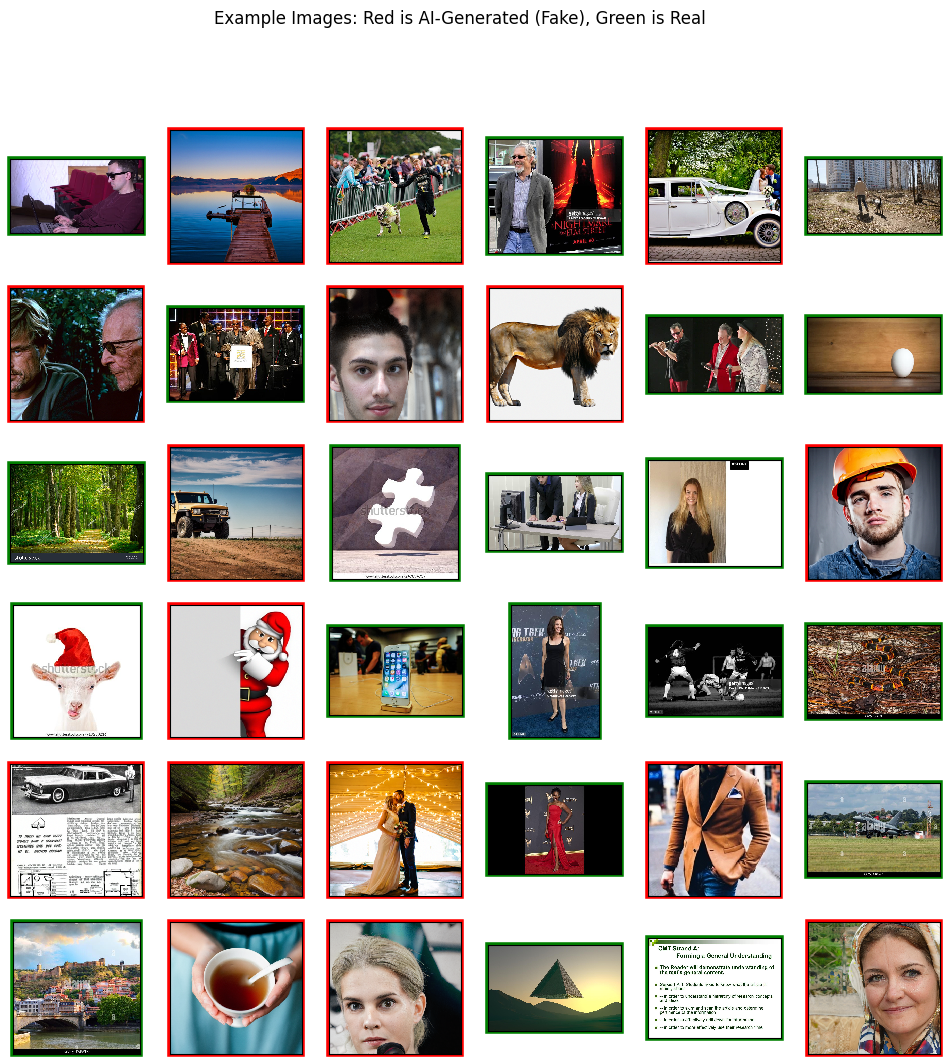

In [11]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(6,6)
fig.set_size_inches(12,12)
fig.bbox_inches = 0
fig.suptitle('Example Images: Red is AI-Generated (Fake), Green is Real')
for row, row_axs in enumerate(axs):
    for col, ax in enumerate(row_axs):
        idx = np.random.choice(len(train_dataset))
        res = train_dataset[idx]
        ax.imshow(res['image'], interpolation='nearest')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.tick_params(left = False, bottom = False)
        ax.patch.set_edgecolor('red' if int(res['label']) == 0 else 'green')
        ax.patch.set_linewidth(4)
        idx += 1

Example item from train dataset

In [12]:
train_dataset[10]

{'image': <PIL.Image.Image image mode=RGB size=256x256>,
 'label': 0.0,
 'pixel_values': tensor([[[ 0.4508,  0.4337,  0.4337,  ...,  0.6221,  0.6049,  0.5878],
          [ 0.4851,  0.4851,  0.5022,  ...,  0.6392,  0.6221,  0.6049],
          [ 0.6049,  0.6221,  0.6392,  ...,  0.6392,  0.6392,  0.6221],
          ...,
          [-0.1657, -0.1143, -0.0458,  ...,  0.0741,  0.0741,  0.0398],
          [-0.0629, -0.1143, -0.1486,  ...,  0.0741,  0.0912,  0.0056],
          [ 0.0056, -0.0972, -0.2171,  ...,  0.1083,  0.1254,  0.0227]],
 
         [[ 1.3957,  1.3782,  1.3606,  ...,  1.4657,  1.4832,  1.4832],
          [ 1.4482,  1.4482,  1.4307,  ...,  1.5357,  1.5357,  1.5182],
          [ 1.5357,  1.5532,  1.5532,  ...,  1.5707,  1.5707,  1.5532],
          ...,
          [ 0.7829,  0.8354,  0.8704,  ...,  0.8529,  0.8880,  0.8529],
          [ 0.9055,  0.8529,  0.8004,  ...,  0.8704,  0.9055,  0.8354],
          [ 0.9930,  0.9055,  0.8004,  ...,  0.9055,  0.9580,  0.8529]],
 
         [[ 

Load Model

In [13]:
num_train = 3000
num_test = 1000

In [14]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [15]:
from random import sample

train_index = sample(range(len(train_dataset)), num_train)
val_index = sample(range(len(val_dataset)), num_test)

train_data_list = []
train_label_list = []
for i in train_index:
  train_data_list.append(train_dataset[i]["pixel_values"])
  train_label_list.append(train_dataset[i]["label"])
train_data = np.stack(train_data_list)
train_data = np.transpose(train_data, (0, 2, 3, 1))
train_label = np.array([[1, 0] if x == 0 else [0, 1] for x in train_label_list])


val_data_list = []
val_label_list = []
for i in val_index:
  val_data_list.append(val_dataset[i]["pixel_values"])
  val_label_list.append(val_dataset[i]["label"])
val_data = np.stack(val_data_list)
val_data = np.transpose(val_data, (0, 2, 3, 1))

val_label = np.array([[1, 0] if x == 0 else [0, 1] for x in val_label_list])



# **IDENTITY BLOCK**
A block of layers with skip connection, where the input activation (say *a[i]*) has the same dimension as the output activation (say *a[i+n]* where n is number of layers in the block) is an identity block in a ResNet.
The skip-connection or shortcut is reffered to the path 1 in the figure. While path 2 is the main path.


In [ ]:
def identity_block(X, f, filters, stage, block):

  '''
  Implementation of identity block described above

  Arguments:
  X -       input tensor to the block of shape (m, n_H_prev, n_W_prev, n_C_prev)
  f -       defines shpae of filter in the middle layer of the main path
  filters - list of integers, defining the number of filters in each layer of the main path
  stage -   defines the block position in the network
  block -   used for naming convention

  Returns:
  X - output is a tensor of shape (n_H, n_W, n_C) which matches (m, n_H_prev, n_W_prev, n_C_prev)
  '''

  # defining base name for block
  conv_base_name = 'res' + str(stage) + block + '_'
  bn_base_name = 'bn' + str(stage) + block + '_'

  # retrieve number of filters in each layer of main path
  # NOTE: f3 must be equal to n_C. That way dimensions of the third component will match the dimension of original input to identity block
  f1, f2, f3 = filters

  # Batch normalization must be performed on the 'channels' axis for input. It is 3, for our case
  bn_axis = 3

  # save input for "addition" to last layer output; step in skip-connection
  X_skip_connection = X

  # ----------------------------------------------------------------------
  # Building layers/component of identity block using Keras functional API

  # First component/layer of main path
  X = Conv2D(filters= f1, kernel_size = (1,1), strides = (1,1), padding='valid', name=conv_base_name+'first_component', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=bn_axis, name=bn_base_name+'first_component')(X)
  X = Activation('relu')(X)

  # Second component/layer of main path
  X = Conv2D(filters= f2, kernel_size = (f,f), strides = (1,1), padding='same', name=conv_base_name+'second_component', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=bn_axis, name=bn_base_name+'second_component')(X)
  X = Activation('relu')(X)

  # Third component/layer of main path
  X = Conv2D(filters= f3, kernel_size = (1,1), strides = (1,1), padding='valid', name=conv_base_name+'third_component', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=bn_axis, name=bn_base_name+'third_component')(X)

  # "Addition step" - skip-connection value merges with main path
  # NOTE: both values have same dimensions at this point, so no operation is required to match dimensions
  X = Add()([X, X_skip_connection])
  X = Activation('relu')(X)

  return X

# **CONVOLUTIONAL** **BLOCK**

This is another kind of block with skip-connection in the ResNet. In this the input to block, and output of last layer in the block don't match in dimensions. So we need to add a convolution step in the skip-connection, before adding the input to last layer's output. This convolution step changes the dimension of the input, so that the dimensions match up for the later addition step.

In [17]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in above figure

    Arguments:
    X -       input tensor to the block of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -       defines shape of filter in the middle layer of the main path
    filters - list of integers, defining the number of filters in each layer of the main path
    stage -   defines the block position in the network
    block -   used for naming convention
    s -       specifies the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # defining base name for block
    conv_base_name = 'res' + str(stage) + block + '_'
    bn_base_name = 'bn' + str(stage) + block + '_'

    # retrieve number of filters in each layer of main path
    f1, f2, f3 = filters

    # Batch normalization must be performed on the 'channels' axis for input. It is 3, for our case
    bn_axis = 3

    # save input for "addition" to last layer output; step in skip-connection
    X_skip_connection = X

    ##### MAIN PATH #####
    # First component of main path
    X = Conv2D(f1, (1, 1), strides = (s,s), padding = 'valid', name = conv_base_name + 'first_component', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = bn_axis, name = bn_base_name + 'first_component')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(f2,  kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_base_name + 'second_component', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = bn_axis, name = bn_base_name + 'second_component')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(f3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_base_name + 'third_component', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = bn_axis, name = bn_base_name + 'third_component')(X)

    ##### Convolve skip-connection value to match its dimensions to third layer output's dimensions ####
    X_skip_connection = Conv2D(f3, (1, 1), strides = (s,s), padding = 'valid', name = conv_base_name + 'merge', kernel_initializer = glorot_uniform(seed=0))(X_skip_connection)
    X_skip_connection = BatchNormalization(axis = 3, name = bn_base_name + 'merge')(X_skip_connection)

    # "Addition step"
    # NOTE: both values have same dimensions at this point
    X = Add()([X, X_skip_connection])
    X = Activation('relu')(X)

    return X

# **RESNET50**
Now that we have our building blocks - Convolutional block and identity block in place, we will build a 50 layer deep neural network with skip connections that implements the follwoing architecture

In [18]:
pip install --upgrade keras tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.1/997.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 87.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.14.1
  Attempting uninstall: tensorflow
    Found existing inst

In [19]:
import os
import h5py
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.utils import layer_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline
import tensorflow.keras.backend as K

In [20]:
import keras



In [21]:
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D,     TimeDistributed
from tensorflow.keras.utils import get_source_inputs
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.keras.metrics import categorical_crossentropy

from tensorflow.keras.models import Model
from tensorflow.python.keras.utils import generic_utils
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import initializers, regularizers

In [22]:
def ResNet50(input_shape = (224, 224, 3), classes = 2):
    """
    Arguments:
    input_shape - shape of the images of the dataset
    classes - number of classes

    Returns:
    model - a Model() instance in Keras

    """

    # plug in input_shape to define the input tensor
    X_input = Input(input_shape)

    # Zero-Padding : pads the input with a pad of (3,3)
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv_1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # NOTE: dimensions of filters that are passed to identity block are such that final layer output
    # in identity block mathces the original input to the block
    # blocks in each stage are alphabetically sequenced

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 224], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 224], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 224], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[224, 224, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [224, 224, 1024], stage=4, block='b')
    X = identity_block(X, 3, [224, 224, 1024], stage=4, block='c')
    X = identity_block(X, 3, [224, 224, 1024], stage=4, block='d')
    X = identity_block(X, 3, [224, 224, 1024], stage=4, block='e')
    X = identity_block(X, 3, [224, 224, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # Average Pooling
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [25]:
model = ResNet50(input_shape = (224, 224, 3), classes = 2)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(train_data, train_label, epochs = 5, batch_size = 500)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/ResNet50/model/RESNET50.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  `tf.saved_model.SaveOptions` object that specifies SavedModel


In [33]:
predictions = model.evaluate(val_data, val_label)
print("Loss = " + str(predictions[0]))
print("Test Accuracy = " + str(predictions[1]))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 5s 94ms/step - loss: 0.7070 - accuracy: 86.7300
Loss = 0.7070021033287048
Test Accuracy = 86.72998809814453
